In [13]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Load the CSV file
print("Loading CSV file...")
df = pd.read_csv("selected_conversations_with_topics_embedded.csv")
print(f"Loaded {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")

# Check if Topic_Embedding column exists
if "Topic_Embedding" not in df.columns:
    raise ValueError("Topic_Embedding column not found in CSV")

# Parse the embeddings from JSON strings
print("\nParsing embeddings...")
embeddings = []
valid_indices = []

for idx, emb_str in enumerate(df["Topic_Embedding"]):
    try:
        if pd.isna(emb_str) or emb_str == "null" or emb_str == "":
            continue
        emb = json.loads(emb_str)
        if emb is not None and isinstance(emb, list):
            embeddings.append(emb)
            valid_indices.append(idx)
    except (json.JSONDecodeError, TypeError) as e:
        print(f"Warning: Failed to parse embedding at row {idx}: {e}")
        continue

embeddings_array = np.array(embeddings)
print(f"Parsed {len(embeddings_array)} valid embeddings")
print(f"Embedding dimension: {embeddings_array.shape[1]}")

# Get corresponding topics for valid embeddings
valid_topics = df.iloc[valid_indices]["Topic"].values if "Topic" in df.columns else None


Loading CSV file...
Loaded 1000 rows
Columns: ['Model', 'Conversation', 'Language', 'Toxic', 'State', 'Country', 'Hour of Day', 'Topic_Embedding', 'Topic', 'Subcluster_Name', 'Subcluster_Description', 'Subcluster_Description_Embedding', 'Cluster', 'Conversation_Embedding']

Parsing embeddings...
Parsed 1000 valid embeddings
Embedding dimension: 3072


In [14]:
# Perform K-means clustering with 50 clusters
print("Performing K-means clustering with 50 clusters...")
n_clusters = 10

# Standardize the embeddings (optional but can help)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_array)

# Perform K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans.fit_predict(embeddings_scaled)

print(f"Clustering complete!")
print(f"Number of clusters: {n_clusters}")
print(f"Cluster label distribution:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Cluster {label}: {count} points")

# Store cluster assignments
df_clustered = pd.DataFrame({
    'index': valid_indices,
    'cluster': cluster_labels
})
if valid_topics is not None:
    df_clustered['topic'] = valid_topics

print(f"\nCluster sizes:")
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
print(cluster_sizes)


Performing K-means clustering with 50 clusters...
Clustering complete!
Number of clusters: 10
Cluster label distribution:
  Cluster 0: 29 points
  Cluster 1: 55 points
  Cluster 2: 257 points
  Cluster 3: 111 points
  Cluster 4: 31 points
  Cluster 5: 173 points
  Cluster 6: 24 points
  Cluster 7: 185 points
  Cluster 8: 120 points
  Cluster 9: 15 points

Cluster sizes:
0     29
1     55
2    257
3    111
4     31
5    173
6     24
7    185
8    120
9     15
Name: count, dtype: int64


In [15]:
# Reduce dimensions using t-SNE for visualization
print("Reducing dimensions using t-SNE (this may take a while)...")
# Use the scaled embeddings for consistency
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
embeddings_2d = tsne.fit_transform(embeddings_scaled)
print("t-SNE reduction complete!")


Reducing dimensions using t-SNE (this may take a while)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 21.330633


/Users/varunsendilraj/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.896362
[t-SNE] KL divergence after 1000 iterations: 1.035731
t-SNE reduction complete!


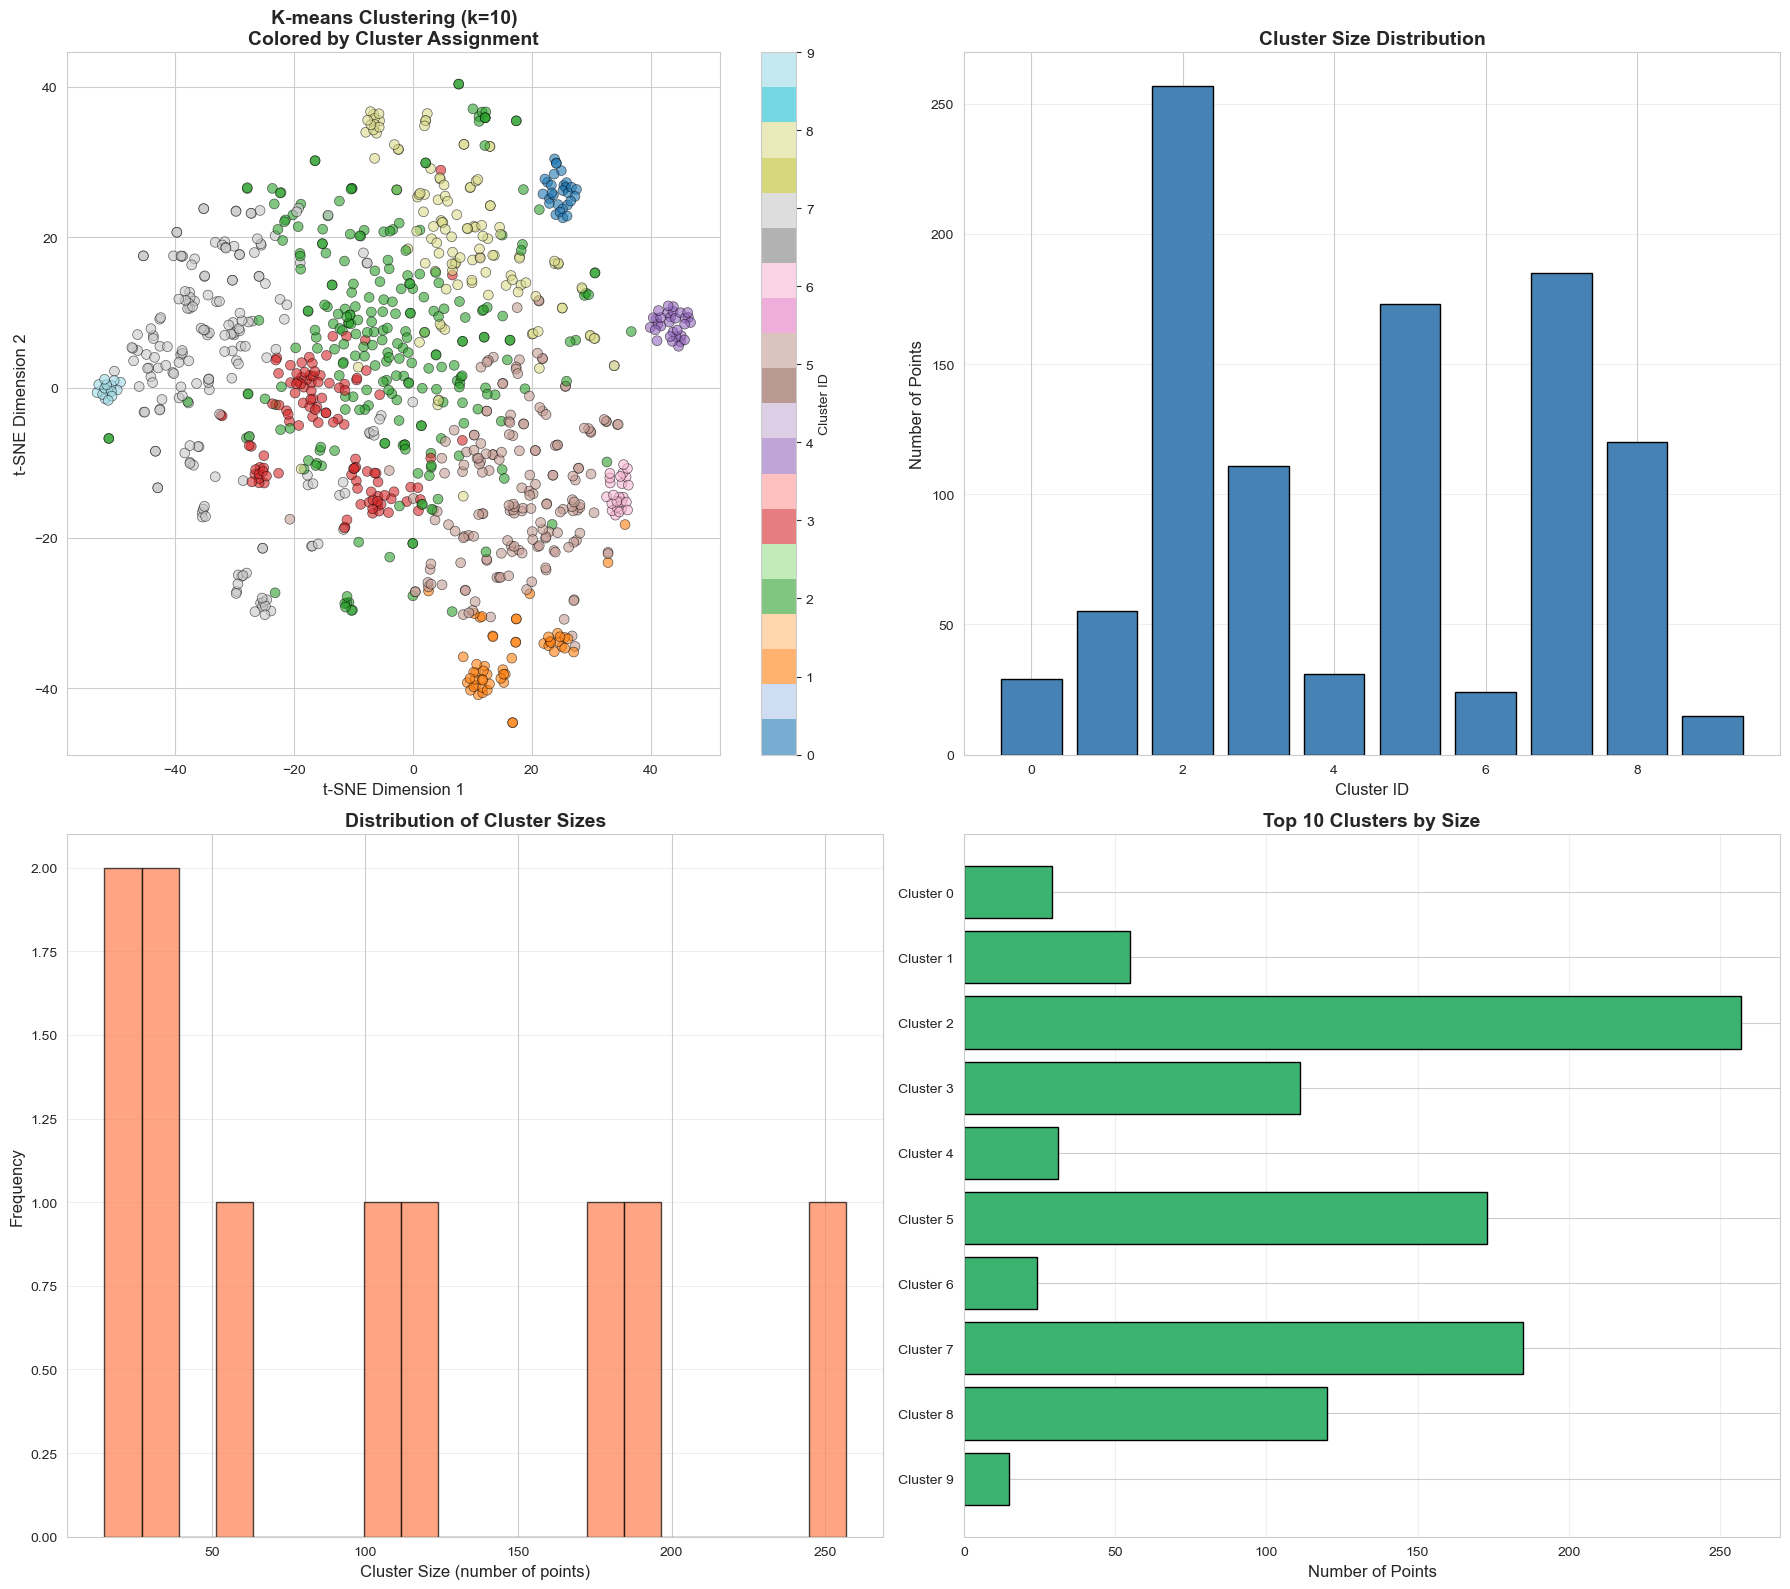


Visualization complete!
Total points: 1000
Number of clusters: 10
Average cluster size: 100.00
Largest cluster size: 257
Smallest cluster size: 15


In [16]:
# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Plot 1: Scatter plot colored by cluster
ax1 = axes[0, 0]
scatter = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=cluster_labels, cmap='tab20', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_title(f'K-means Clustering (k={n_clusters})\nColored by Cluster Assignment', fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
plt.colorbar(scatter, ax=ax1, label='Cluster ID')

# Plot 2: Cluster size distribution
ax2 = axes[0, 1]
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
ax2.bar(cluster_sizes.index, cluster_sizes.values, color='steelblue', edgecolor='black')
ax2.set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Cluster ID', fontsize=12)
ax2.set_ylabel('Number of Points', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Histogram of cluster sizes
ax3 = axes[1, 0]
ax3.hist(cluster_sizes.values, bins=20, color='coral', edgecolor='black', alpha=0.7)
ax3.set_title('Distribution of Cluster Sizes', fontsize=14, fontweight='bold')
ax3.set_xlabel('Cluster Size (number of points)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Top clusters by size
ax4 = axes[1, 1]
top_clusters = cluster_sizes.head(10)
ax4.barh(range(len(top_clusters)), top_clusters.values, color='mediumseagreen', edgecolor='black')
ax4.set_yticks(range(len(top_clusters)))
ax4.set_yticklabels([f'Cluster {idx}' for idx in top_clusters.index])
ax4.set_title('Top 10 Clusters by Size', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Points', fontsize=12)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualization complete!")
print(f"Total points: {len(embeddings_2d)}")
print(f"Number of clusters: {n_clusters}")
print(f"Average cluster size: {cluster_sizes.mean():.2f}")
print(f"Largest cluster size: {cluster_sizes.max()}")
print(f"Smallest cluster size: {cluster_sizes.min()}")


In [17]:
# Show sample topics from each cluster (if topics are available)
if valid_topics is not None:
    print("\n" + "="*80)
    print("Sample topics from each cluster:")
    print("="*80)
    
    for cluster_id in sorted(np.unique(cluster_labels)):
        cluster_mask = cluster_labels == cluster_id
        cluster_topics = valid_topics[cluster_mask]
        
        print(f"\nCluster {cluster_id} ({len(cluster_topics)} topics):")
        print("-" * 60)
        # Show up to 5 sample topics
        sample_size = min(5, len(cluster_topics))
        for topic in cluster_topics[:sample_size]:
            # Truncate if too long
            display_topic = topic if len(topic) <= 80 else topic[:77] + "..."
            print(f"  - {display_topic}")
        if len(cluster_topics) > sample_size:
            print(f"  ... and {len(cluster_topics) - sample_size} more")
else:
    print("\nTopics not available for display")



Sample topics from each cluster:

Cluster 0 (29 topics):
------------------------------------------------------------
  - The user asked for the meaning of the book "Pindar Odes," and the assistant e...
  - The user repeatedly asked for concise 50-word meanings of four books of Greek...
  - The user asked for the meaning of seven specific ancient Greek books, each wi...
  - The user repeatedly asked for the meaning of seven specific ancient Greek boo...
  - The user asked for the meaning of two books, Apollodorus Epitome and Hesiod S...
  ... and 24 more

Cluster 1 (55 topics):
------------------------------------------------------------
  - The user first asked for a simple-minded speech from Gendry expressing his re...
  - The user requested three interconnected stories about a fictional reunion of ...
  - The user first asked for a list of movies where a female character performs a...
  - The user asked if there is a scene in the movie "Catch Me If You Can" where t...
  - The user 

In [18]:
import os
from openai import OpenAI
from dotenv import load_dotenv
import time
from tqdm import tqdm

load_dotenv()

# Initialize DeepSeek client
deepseek_api_key = os.environ.get("DEEPSEEK_API_KEY")
if not deepseek_api_key:
    raise ValueError("DEEPSEEK_API_KEY not found in environment variables. Please set it in your .env file.")

deepseek_client = OpenAI(
    api_key=deepseek_api_key,
    base_url="https://api.deepseek.com"
)

print("DeepSeek client initialized successfully!")


DeepSeek client initialized successfully!


In [19]:
# Group topics by cluster
cluster_topics_dict = {}
for cluster_id in sorted(np.unique(cluster_labels)):
    cluster_mask = cluster_labels == cluster_id
    cluster_topics = valid_topics[cluster_mask].tolist()
    cluster_topics_dict[cluster_id] = cluster_topics

print(f"Grouped topics into {len(cluster_topics_dict)} clusters")
print(f"Cluster sizes range from {min(len(topics) for topics in cluster_topics_dict.values())} to {max(len(topics) for topics in cluster_topics_dict.values())} topics")


Grouped topics into 10 clusters
Cluster sizes range from 15 to 257 topics


In [20]:
def generate_cluster_label_and_description(client, topics_list, cluster_id):
    """Generate a label and description for a cluster using DeepSeek."""
    
    # Create a prompt with all topics
    topics_text = "\n".join([f"- {topic}" for topic in topics_list])
    
    prompt = f"""You are analyzing a cluster of related conversation topics. Below are all the topics in this cluster:

{topics_text}

Please analyze these topics and provide:
1. A short, concise label (2-5 words) that captures the main theme
2. A detailed description (2-3 sentences) explaining what this cluster represents

Format your response as JSON with exactly these keys:
- "label": the short label
- "description": the detailed description

Only return the JSON, no other text."""
    
    try:
        response = client.chat.completions.create(
            model="deepseek-chat",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that analyzes and categorizes topics. Always respond with valid JSON only."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,  # Lower temperature for more consistent results
            stream=False
        )
        
        content = response.choices[0].message.content.strip()
        
        # Try to extract JSON from the response
        # Sometimes the response might have markdown code blocks
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0].strip()
        elif "```" in content:
            content = content.split("```")[1].split("```")[0].strip()
        
        # Parse JSON
        result = json.loads(content)
        
        return {
            "cluster_id": cluster_id,
            "label": result.get("label", "Unknown"),
            "description": result.get("description", "No description available"),
            "num_topics": len(topics_list),
            "status": "success"
        }
    except Exception as e:
        print(f"Error processing cluster {cluster_id}: {e}")
        return {
            "cluster_id": cluster_id,
            "label": f"Cluster_{cluster_id}",
            "description": f"Error generating description: {str(e)}",
            "num_topics": len(topics_list),
            "status": "error"
        }

print("Function defined. Ready to generate labels!")


Function defined. Ready to generate labels!


In [21]:
# Generate labels for all clusters
print("Generating labels and descriptions for all clusters using DeepSeek...")
print("This may take a few minutes depending on the number of clusters.\n")

cluster_labels_results = []

# Process clusters with progress bar
for cluster_id in tqdm(sorted(cluster_topics_dict.keys()), desc="Labeling clusters"):
    topics = cluster_topics_dict[cluster_id]
    result = generate_cluster_label_and_description(deepseek_client, topics, cluster_id)
    cluster_labels_results.append(result)
    
    # Small delay to avoid rate limiting
    time.sleep(0.5)

print(f"\nCompleted labeling {len(cluster_labels_results)} clusters!")


Generating labels and descriptions for all clusters using DeepSeek...
This may take a few minutes depending on the number of clusters.



Labeling clusters: 100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Completed labeling 10 clusters!


In [22]:
# Create a DataFrame with cluster labels and descriptions
df_cluster_labels = pd.DataFrame(cluster_labels_results)
df_cluster_labels = df_cluster_labels.sort_values('cluster_id')

# Display the results
print("\n" + "="*100)
print("CLUSTER LABELS AND DESCRIPTIONS")
print("="*100)

for _, row in df_cluster_labels.iterrows():
    print(f"\n{'='*100}")
    print(f"Cluster {int(row['cluster_id'])} ({row['num_topics']} topics)")
    print(f"{'='*100}")
    print(f"Label: {row['label']}")
    print(f"Description: {row['description']}")
    print(f"Status: {row['status']}")
    
    # Show a few sample topics from this cluster
    topics = cluster_topics_dict[int(row['cluster_id'])]
    print(f"\nSample topics ({min(3, len(topics))} of {len(topics)}):")
    for topic in topics[:3]:
        display_topic = topic if len(topic) <= 80 else topic[:77] + "..."
        print(f"  - {display_topic}")

print(f"\n\n{'='*100}")
print(f"Summary: {len(df_cluster_labels)} clusters labeled successfully")
print(f"{'='*100}")


CLUSTER LABELS AND DESCRIPTIONS

Cluster 0 (29 topics)
Label: Structured Book Descriptions
Description: This cluster represents a series of user requests for concise, formatted descriptions of classical Greek literary works, including poetry, plays, and philosophical texts. The user consistently specifies strict formatting rules, such as word counts, exclusion of titles and authors, and SQL update statement formats, while the assistant reliably complies by providing tailored summaries that highlight content and themes.
Status: success

Sample topics (3 of 29):
  - The user asked for the meaning of the book "Pindar Odes," and the assistant e...
  - The user repeatedly asked for concise 50-word meanings of four books of Greek...
  - The user asked for the meaning of seven specific ancient Greek books, each wi...

Cluster 1 (55 topics)
Label: Fictional Scene Scripting
Description: This cluster represents a collection of user requests for detailed, often genre-specific scripts and scenes 

In [23]:
# Save cluster labels to CSV
output_file = "cluster_labels_descriptions.csv"
df_cluster_labels.to_csv(output_file, index=False)
print(f"\nCluster labels and descriptions saved to: {output_file}")

# Also create a mapping DataFrame that can be merged with the original data
df_cluster_mapping = df_cluster_labels[['cluster_id', 'label', 'description']].copy()
df_cluster_mapping.columns = ['cluster', 'cluster_label', 'cluster_description']

# Display summary statistics
print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)
print(f"Total clusters: {len(df_cluster_labels)}")
print(f"Successfully labeled: {len(df_cluster_labels[df_cluster_labels['status'] == 'success'])}")
print(f"Errors: {len(df_cluster_labels[df_cluster_labels['status'] == 'error'])}")
print(f"Average topics per cluster: {df_cluster_labels['num_topics'].mean():.2f}")
print(f"Min topics in a cluster: {df_cluster_labels['num_topics'].min()}")
print(f"Max topics in a cluster: {df_cluster_labels['num_topics'].max()}")



Cluster labels and descriptions saved to: cluster_labels_descriptions.csv

SUMMARY STATISTICS
Total clusters: 10
Successfully labeled: 10
Errors: 0
Average topics per cluster: 100.00
Min topics in a cluster: 15
Max topics in a cluster: 257


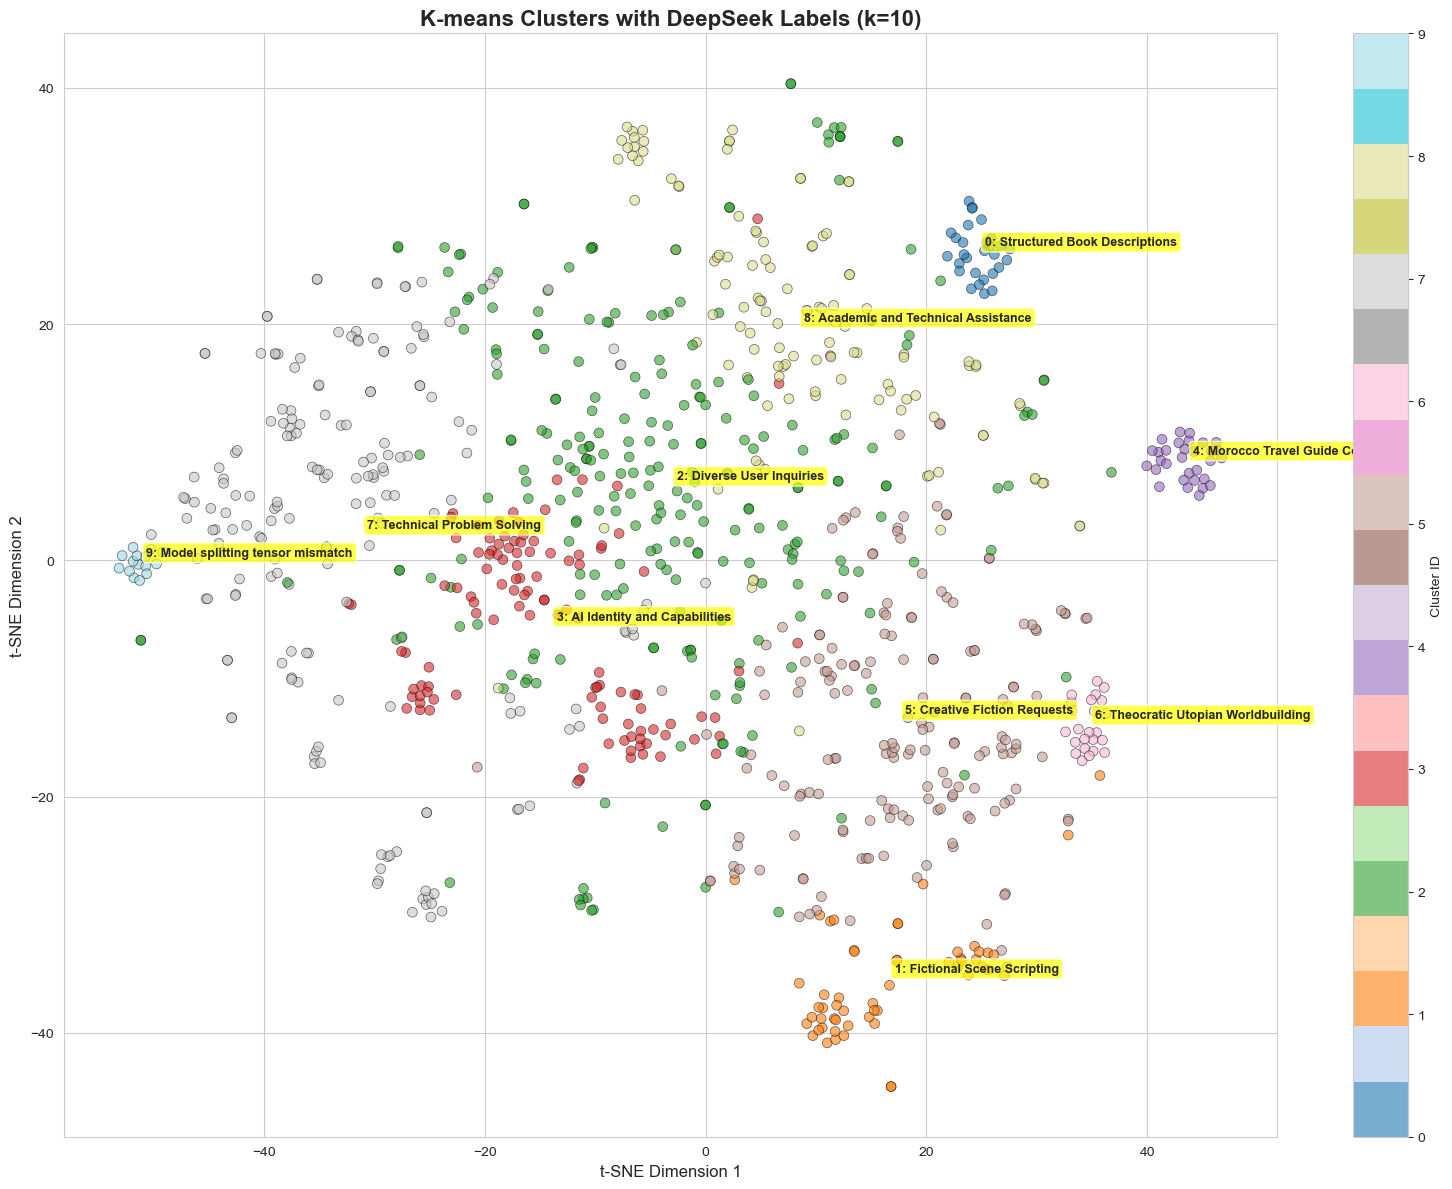

Visualization with cluster labels created!


In [24]:
# Create a visualization with cluster labels
fig, ax = plt.subplots(figsize=(16, 12))

# Create scatter plot
scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=cluster_labels, cmap='tab20', s=50, alpha=0.6, 
                     edgecolors='black', linewidth=0.5)

# Add cluster labels as annotations (for top 10 largest clusters to avoid clutter)
cluster_sizes = pd.Series(cluster_labels).value_counts()
top_clusters = cluster_sizes.head(10).index

for cluster_id in top_clusters:
    # Find centroid of cluster in 2D space
    cluster_mask = cluster_labels == cluster_id
    cluster_points = embeddings_2d[cluster_mask]
    centroid = cluster_points.mean(axis=0)
    
    # Get label for this cluster
    label_row = df_cluster_labels[df_cluster_labels['cluster_id'] == cluster_id]
    if not label_row.empty:
        label_text = label_row.iloc[0]['label']
        # Add annotation
        ax.annotate(f"{cluster_id}: {label_text}", 
                   xy=centroid, 
                   xytext=(5, 5), 
                   textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   fontsize=9,
                   fontweight='bold')

ax.set_title(f'K-means Clusters with DeepSeek Labels (k={n_clusters})', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
plt.colorbar(scatter, ax=ax, label='Cluster ID')
plt.tight_layout()
plt.show()

print("Visualization with cluster labels created!")
